<a href="https://colab.research.google.com/github/simsekergun/RingDimensionDS/blob/main/Dimension_Prediction_from_Integrated_Dispersion_Data_SM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this project is to predict the dimensions of a ring (width and height) from the integrated dispersion datasets. The datasets can be found at https://github.com/simsekergun/RingDimensionDS/. In all datasets, the first two column are the dimensions (Y), and the following columns are the integrated dispersion values computed at 171 wavelengths ranging from 750 nm to 1600 nm.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Let's get our datasets

In [2]:
XY_train = pd.read_csv('https://raw.githubusercontent.com/simsekergun/RingDimensionDS/refs/heads/main/datasets/SiNtrainingDint1SM1.csv', header=None)
XY_test = pd.read_csv('https://raw.githubusercontent.com/simsekergun/RingDimensionDS/refs/heads/main/datasets/SiNtestDint1SM1.csv', header=None)

In [3]:
XY_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,163,164,165,166,167,168,169,170,171,172
0,7.500000e-07,6.200000e-07,-1613.7,-1328.1,-1069.0,-834.79,-623.64,-433.98,-264.29,-113.14,...,-12710.0,-13148.0,-13595.0,-14051.0,-14517.0,-14992.0,-15476.0,-15970.0,-16473.0,-16986.0
1,7.600000e-07,6.200000e-07,-1657.5,-1363.9,-1097.4,-856.29,-638.71,-443.08,-267.87,-111.65,...,-11358.0,-11764.0,-12180.0,-12604.0,-13037.0,-13479.0,-13931.0,-14391.0,-14860.0,-15338.0
2,7.700000e-07,6.200000e-07,-1739.4,-1436.7,-1161.6,-912.35,-687.20,-484.49,-302.67,-140.28,...,-10111.0,-10489.0,-10874.0,-11268.0,-11671.0,-12083.0,-12503.0,-12931.0,-13369.0,-13815.0


In [4]:
X_train = XY_train.iloc[:,2::]
Y_train = XY_train.iloc[:,[0,1]]*1e9  # convert meters to nanometers

Y_test = XY_test.iloc[:,[0,1]]*1e9
X_test = XY_test.iloc[:,2::]

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(441, 171) (441, 2) (44, 171) (44, 2)


In [5]:
# let's define a function to plot truth vs prediction and report errors
def compare_results(y_actual, pred1, pred2):
  # Create a figure with 1 row and 2 columns of subplots
  plt.figure(figsize=(8, 4))  # Wider figure to accommodate side-by-side plots

  # First subplot (Widths)
  plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
  plt.plot([np.min(y_actual[:,0]), np.max(y_actual[:,0])],
          [np.min(y_actual[:,0]), np.max(y_actual[:,0])],
          color='r', linestyle='dashed')
  plt.plot(y_actual[:, 0], pred1, 'o')
  plt.title('Comparison of Actual and Predicted Widths')
  plt.xlabel('Actual')
  plt.ylabel('Prediction')
  plt.grid()

  # Second subplot (Heights)
  plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
  plt.plot([np.min(y_actual[:,1]), np.max(y_actual[:,1])],
          [np.min(y_actual[:,1]), np.max(y_actual[:,1])],
          color='r', linestyle='dashed')
  plt.plot(y_actual[:, 1], pred2, 'o')
  plt.title('Comparison of Actual and Predicted Heights')
  plt.xlabel('Actual')
  plt.ylabel('Prediction')
  plt.grid()

  # Adjust layout to prevent overlap
  plt.tight_layout()
  plt.show()

  # Calculate absolute errors for the first output variable
  absolute_errors = np.abs(y_actual[:, 0] - pred1)

  # 1. Absolute Error Metrics
  min_abs_error = np.min(absolute_errors)
  mean_abs_error = np.mean(absolute_errors)
  max_abs_error = np.max(absolute_errors)

  print("Absolute Error Metrics for Width:")
  print(f"Minimum Absolute Error (nm): {min_abs_error:.4f}")
  print(f"Mean Absolute Error (nm): {mean_abs_error:.4f}")
  print(f"Maximum Absolute Error (nm): {max_abs_error:.4f}")
  print()


  # Calculate absolute errors for the first output variable
  absolute_errors = np.abs(y_actual[:, 1] - pred2)

  # 1. Absolute Error Metrics
  min_abs_error = np.min(absolute_errors)
  mean_abs_error = np.mean(absolute_errors)
  max_abs_error = np.max(absolute_errors)

  print("Absolute Error Metrics for Height:")
  print(f"Minimum Absolute Error (nm): {min_abs_error:.4f}")
  print(f"Mean Absolute Error (nm): {mean_abs_error:.4f}")
  print(f"Maximum Absolute Error (nm): {max_abs_error:.4f}")
  print()

<b> Now, let's build different neural networks and see which one performs the best</b>

In [6]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Dense, LeakyReLU, Input, Multiply, Activation, Dropout, LayerNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [7]:
# Let's scale the datasets
xmax = 20000
column_means = Y_train.mean()
column_maxs = Y_train.max()
column_mins = Y_train.min()

y_actual = Y_test.values

X_train_scaled = X_train.values/xmax
X_test_scaled = X_test.values/xmax
Y_train_sc = (Y_train-column_means)/(column_maxs-column_means)
Y_test_sc = (Y_test-column_means)/(column_maxs-column_means)
Y_train_scaled = Y_train_sc.values
Y_test_scaled = Y_test_sc.values

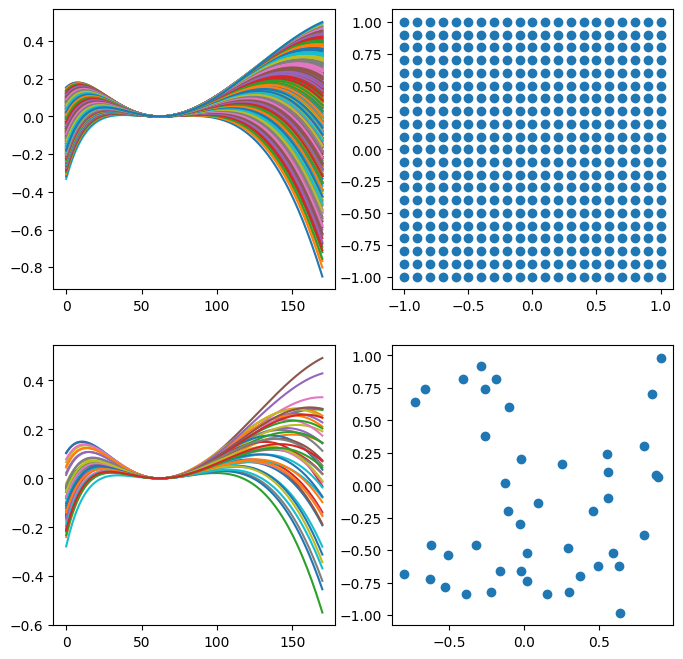

In [8]:
# Let's visaulize our scaled dataset
plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.plot(X_train_scaled.T)

plt.subplot(2, 2, 2)
plt.plot(Y_train_scaled[:,0],Y_train_scaled[:,1],'o')

plt.subplot(2, 2, 3)
plt.plot(X_test_scaled.T)

plt.subplot(2, 2, 4)
plt.plot(Y_test_scaled[:,0],Y_test_scaled[:,1],'o')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training MAE: 0.0744
Test MAE: 0.0103
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


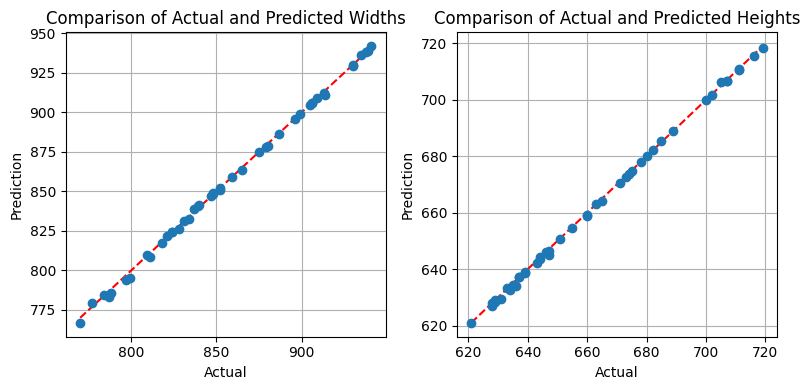

Absolute Error Metrics for Width:
Minimum Absolute Error (nm): 0.0076
Mean Absolute Error (nm): 1.0191
Maximum Absolute Error (nm): 3.7367

Absolute Error Metrics for Height:
Minimum Absolute Error (nm): 0.0001
Mean Absolute Error (nm): 0.5193
Maximum Absolute Error (nm): 2.1286



In [9]:
# Let's build our first neural network model
model = Sequential([
    Dense(128, input_shape=(171,)),
    LeakyReLU(0.5),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='linear')  # Output layer with 2 units for your 2 outputs
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, Y_train_scaled,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test_scaled, Y_test_scaled),
                    verbose=0)

# Evaluate the model
train_loss, train_mae = model.evaluate(X_train_scaled, Y_train_scaled, verbose=0)
test_loss, test_mae = model.evaluate(X_test_scaled, Y_test_scaled, verbose=0)

print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Predict on test data
y_pred_scaled = model.predict(X_test_scaled)

pred1 = y_pred_scaled[:,0]*(column_maxs[0]-column_means[0])+column_means[0]
pred2 = y_pred_scaled[:,1]*(column_maxs[1]-column_means[1])+column_means[1]

compare_results(y_actual, pred1, pred2)

Network 2

In [10]:
# Build model with regularization
model = Sequential([
    Dense(256, activation='relu', input_shape=(171,),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(128, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='linear')
])

# Add callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

# Compile with lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='mse',
              metrics=['mae'])

# Train with more epochs
history = model.fit(X_train_scaled, Y_train_scaled,
                    epochs=300,
                    batch_size=32,
                    validation_data=(X_test_scaled, Y_test_scaled),
                    callbacks=callbacks,
                    verbose=0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


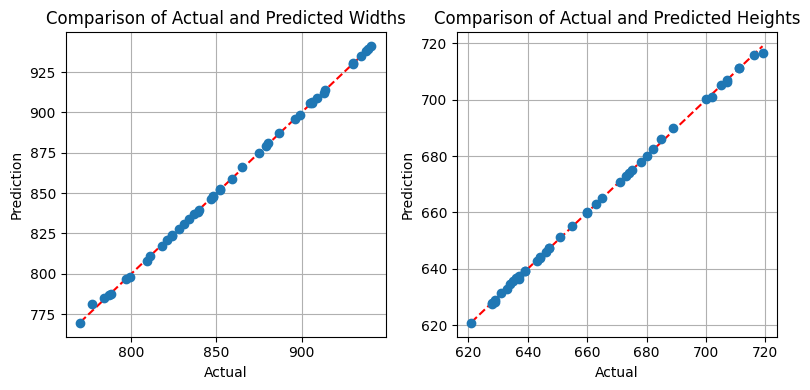

Absolute Error Metrics for Width:
Minimum Absolute Error (nm): 0.0188
Mean Absolute Error (nm): 0.4822
Maximum Absolute Error (nm): 4.4834

Absolute Error Metrics for Height:
Minimum Absolute Error (nm): 0.0210
Mean Absolute Error (nm): 0.3584
Maximum Absolute Error (nm): 2.5406



In [11]:
y_pred_scaled = model.predict(X_test_scaled)

pred1 = y_pred_scaled[:,0]*(column_maxs[0]-column_means[0])+column_means[0]
pred2 = y_pred_scaled[:,1]*(column_maxs[1]-column_means[1])+column_means[1]

compare_results(y_actual, pred1, pred2)

Network 3

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


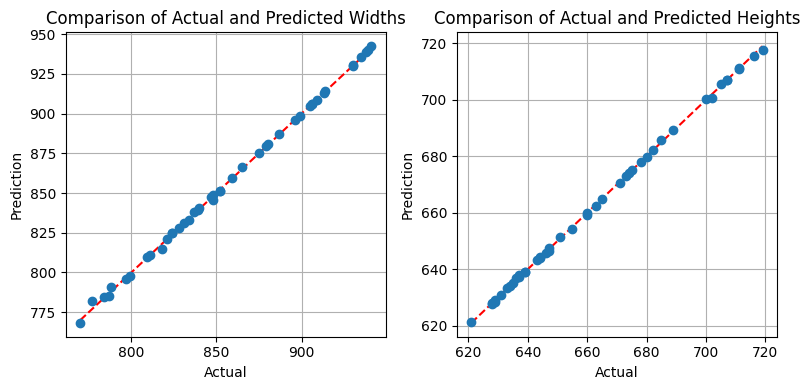

Absolute Error Metrics for Width:
Minimum Absolute Error (nm): 0.0106
Mean Absolute Error (nm): 0.8125
Maximum Absolute Error (nm): 4.8997

Absolute Error Metrics for Height:
Minimum Absolute Error (nm): 0.0097
Mean Absolute Error (nm): 0.3388
Maximum Absolute Error (nm): 1.4095



In [12]:
inputs = tf.keras.Input(shape=(171,))
x = Dense(128, activation='relu')(inputs)
residual = x

# Residual block 1
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Add()([x, residual])
residual = x

# Residual block 2
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Add()([x, residual])

outputs = Dense(2, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.0007),
              loss='mse',
              metrics=['mae'])

# Train with more epochs
history = model.fit(X_train_scaled, Y_train_scaled,
                    epochs=300,
                    batch_size=32,
                    validation_data=(X_test_scaled, Y_test_scaled),
                    callbacks=callbacks,
                    verbose=0)

y_pred_scaled = model.predict(X_test_scaled)

pred1 = y_pred_scaled[:,0]*(column_maxs[0]-column_means[0])+column_means[0]
pred2 = y_pred_scaled[:,1]*(column_maxs[1]-column_means[1])+column_means[1]

compare_results(y_actual, pred1, pred2)

Network 4

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


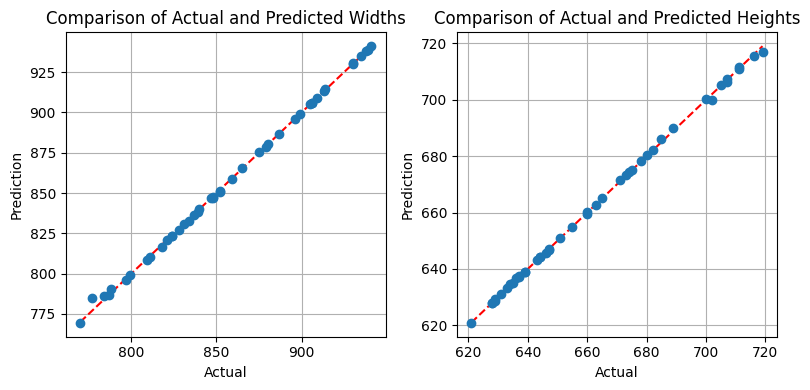

Absolute Error Metrics for Width:
Minimum Absolute Error (nm): 0.0104
Mean Absolute Error (nm): 0.6981
Maximum Absolute Error (nm): 8.0159

Absolute Error Metrics for Height:
Minimum Absolute Error (nm): 0.0271
Mean Absolute Error (nm): 0.3995
Maximum Absolute Error (nm): 2.2532



In [13]:
input_layer = tf.keras.Input(shape=(171,))

# Wide path (direct connections)
wide = Dense(64, activation='relu')(input_layer)

# Deep path
deep = Dense(128, activation='relu')(input_layer)
deep = Dense(128, activation='relu')(deep)
deep = Dense(64, activation='relu')(deep)

# Concatenate
merged = tf.keras.layers.concatenate([wide, deep])
output = Dense(2, activation='linear')(merged)

model = tf.keras.Model(inputs=input_layer, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

# Train with more epochs
history = model.fit(X_train_scaled, Y_train_scaled,
                    epochs=300,
                    batch_size=32,
                    validation_data=(X_test_scaled, Y_test_scaled),
                    callbacks=callbacks,
                    verbose=0)

# Predict on test data
y_pred_scaled = model.predict(X_test_scaled)

pred1 = y_pred_scaled[:,0]*(column_maxs[0]-column_means[0])+column_means[0]
pred2 = y_pred_scaled[:,1]*(column_maxs[1]-column_means[1])+column_means[1]

compare_results(y_actual, pred1, pred2)

In [14]:
def get_N_vs_errors(ind):
  N = len(ind)
  input_layer = tf.keras.Input(shape=(N,))

  # Wide path (direct connections)
  wide = Dense(64, activation='relu')(input_layer)

  # Deep path
  deep = Dense(128, activation='relu')(input_layer)
  deep = Dense(128, activation='relu')(deep)
  deep = Dense(64, activation='relu')(deep)

  # Concatenate
  merged = tf.keras.layers.concatenate([wide, deep])
  output = Dense(2, activation='linear')(merged)

  model = tf.keras.Model(inputs=input_layer, outputs=output)

  model.compile(optimizer=Adam(learning_rate=0.001),
                loss='mse',
                metrics=['mae'])

  # Train with more epochs
  history = model.fit(X_train_scaled[:,ind], Y_train_scaled,
                      epochs=300,
                      batch_size=32,
                      validation_data=(X_test_scaled[:,ind], Y_test_scaled),
                      callbacks=callbacks,
                      verbose=0)

  # Predict on test data
  y_pred_scaled = model.predict(X_test_scaled[:,ind])
  pred1 = y_pred_scaled[:,0]*(column_maxs[0]-column_means[0])+column_means[0]
  pred2 = y_pred_scaled[:,1]*(column_maxs[1]-column_means[1])+column_means[1]
  absolute_errors1 = np.abs(y_actual[:, 0] - pred1)
  absolute_errors2 = np.abs(y_actual[:, 1] - pred2)

  return (np.min(absolute_errors1), np.mean(absolute_errors1), np.max(absolute_errors1), np.min(absolute_errors2), np.mean(absolute_errors2), np.max(absolute_errors2))

In [15]:
no_trials = 20
no_regions = 3
Nmax = 171

# Dint_sample_range = np.arange(3, round((Nmax-2)/no_regions) + 1)
Dint_sample_range = np.array([5, 10, 15, 20, 25, 30, 40, 50])
error_val = np.zeros((len(Dint_sample_range), no_trials))

min_errors1 = np.zeros((len(Dint_sample_range),no_trials))
mean_errors1 = np.zeros((len(Dint_sample_range),no_trials))
max_errors1 = np.zeros((len(Dint_sample_range),no_trials))
min_errors2 = np.zeros((len(Dint_sample_range),no_trials))
mean_errors2 = np.zeros((len(Dint_sample_range),no_trials))
max_errors2 = np.zeros((len(Dint_sample_range),no_trials))

for irang in range(len(Dint_sample_range)):
    no_samples = Dint_sample_range[irang]  # choose an odd number

    for itx in range(no_trials):
        Dintsample = Nmax - 2
        ind_rand_samples = np.array([], dtype=int)  # Ensure integer type

        for irx in range(1, no_regions + 1):
            nmax = int(np.floor(Dintsample/no_regions))

            l1 = nmax * (irx - 1) + round(no_samples/2)
            l2 = nmax * irx - round(no_samples/2)

            if l1 < l2:
                rand_center = np.random.randint(l1, l2 + 1)
            else:
                rand_center = np.random.randint(l2, l1 + 1)

            # Create integer range and ensure proper bounds
            start = int(rand_center - np.floor(no_samples/2))
            end = int(rand_center + np.floor(no_samples/2))
            samples = np.arange(start, end + 1)

            ind_rand_samples = np.concatenate((ind_rand_samples, samples))

        # Filter and convert to integers
        ind_rand_samples = ind_rand_samples[(ind_rand_samples <= Dintsample) &
                                           (ind_rand_samples >= 1)].astype(int)
        mi1, me1, mx1, mi2, me2, mx2 = get_N_vs_errors(ind_rand_samples)
        min_errors1[irang, itx] = mi1
        mean_errors1[irang, itx] = me1
        max_errors1[irang, itx] = mx1
        min_errors2[irang, itx] = mi2
        mean_errors2[irang, itx] = me2
        max_errors2[irang, itx] = mx2
        print(mi1, me1, mx1, mi2, me2, mx2)



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
0.010392904281616211 0.6682593886825171 7.48103666305542 0.007948815822601318 0.3433752635663206 1.848090410232544
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
0.0383833646774292 3.4924661937085064 15.49805212020874 0.039080023765563965 2.623529053716497 8.95034146308899
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
0.07666563987731934 3.580021799796007 16.370455503463745 0.021802425384521484 2.3856816823509606 8.83049589395523
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
0.026731491088867188 1.7924053150821815 20.641688585281372 0.003544449806213379 1.0507381021637807 6.165934324264526
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
0.0969243049621582 2.2636842245066706 17.741302728652954 0.10647010803222656 1.4414263157681986 7.131744146347046
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
0.005198001861572266 0.6619512902742083 7.568631649017334 0.02191901206970215 0.4958659562028267 2.830152750015259
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
0.02112889289855957 0.9415642475201325 13.09285

In [16]:
from google.colab import files

In [17]:
df = pd.DataFrame(min_errors1)
csv_file = 'min_errors1_data_SM1.csv'
df.to_csv(csv_file, index=False)
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
df = pd.DataFrame(mean_errors1)
csv_file = 'mean_errors1_data_SM1.csv'
df.to_csv(csv_file, index=False)
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
df = pd.DataFrame(max_errors1)
csv_file = 'max_errors1_data_SM1.csv'
df.to_csv(csv_file, index=False)
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
df = pd.DataFrame(min_errors2)
csv_file = 'min_errors2_data_SM1.csv'
df.to_csv(csv_file, index=False)
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
df = pd.DataFrame(mean_errors2)
csv_file = 'mean_errors2_data_SM1_50.csv'
df.to_csv(csv_file, index=False)
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
df = pd.DataFrame(max_errors2)
csv_file = 'max_errors2_data_SM1_50.csv'
df.to_csv(csv_file, index=False)
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>